In [1]:
import numpy as np
import matplotlib.pyplot as plt
import optuna
import pandas as pd
from tqdm import tqdm
import scipy

/home/james/Repo/PhD Repo/time_series_clustering/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from time_series.time_series_models import KernelRidgeRegression, RascuttiModel
from time_series.data_generators import LorenzGenerator
from time_series.kernels import GaussianKernel
from time_series.evaluators import MeanSquaredError

2025-10-10 15:28:03.215 | INFO     | time_series.config:<module>:13 - PROJ_ROOT path is: /home/james/Repo/PhD Repo/time_series_clustering


In [3]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [4]:
class TimeSeriesData:
    def __init__(self, X, y=None, train_val_test_split=None, dataset_name=None, parameters=None, **kwargs):
        self.__dict__.update(kwargs)
        self.X = X
        self.y = y

        self.N = len(X)
        self.indices = np.arange(self.N)
        self.tvt_split = train_val_test_split
        self.dataset_name = dataset_name if dataset_name else ""
        self.parameters = parameters if parameters else {}

    def train_data(self):
        min_idx = 0
        max_idx = int(self.tvt_split[0]*self.N)
        self.train_idx = self.indices[min_idx:max_idx]

        if type(self.y) == type(None):
            return self.X[self.train_idx], None

        return self.X[self.train_idx], self.y[self.train_idx]

    def val_data(self, lag=0):
        min_idx = int(self.tvt_split[0]*self.N) - lag
        max_idx = int((self.tvt_split[0] + self.tvt_split[1])*self.N)
        self.val_idx = self.indices[min_idx:max_idx]

        if type(self.y) == type(None):
            return self.X[self.val_idx], None

        return self.X[self.val_idx], self.y[self.val_idx]

    def test_data(self, lag=0):
        min_idx = int((self.tvt_split[0] + self.tvt_split[1])*self.N) - lag
        max_idx = self.N 
        self.test_idx = self.indices[min_idx:max_idx]

        if type(self.y) == type(None):
            return self.X[self.test_idx], None

        return self.X[self.test_idx], self.y[self.test_idx]
    
    def drop_data(self):
        self.X = None
        self.y = None

In [5]:
noise_cov = 0
dt = 1e-2
T = 5

dynamics = [
    dict(rho=14, sigma=10, beta=8/3),
    dict(rho=28, sigma=10, beta=8/3),
    dict(rho=28, sigma=1, beta=8/3)
]

starting_points = [
    [1, 1, 1],
    [1, 2, 1],
    [1, 1, 2],
    [2, 1, 1],
    [-1,-1,1]
]

datasets = []
labels = []
for di, d in enumerate(dynamics):
    for s in starting_points:
        _, data = LorenzGenerator(noise_mean=[0,0,0], noise_covariance=noise_cov, dt=dt, T=T, x0=s, **d)()
        datasets.append(
            TimeSeriesData(
                X = data[:-1],
                y = data[1:],
                train_val_test_split=[0.5, 0.3, 0.2],
                labels = [f"X_{di}", f"Y_{di}", f"Z_{di}"],
                dataset_label = di,
                parameters=d   
            )
        )

        print(f"x0: {s}, ", str(d))

x0: [1, 1, 1],  {'rho': 14, 'sigma': 10, 'beta': 2.6666666666666665}
x0: [1, 2, 1],  {'rho': 14, 'sigma': 10, 'beta': 2.6666666666666665}
x0: [1, 1, 2],  {'rho': 14, 'sigma': 10, 'beta': 2.6666666666666665}
x0: [2, 1, 1],  {'rho': 14, 'sigma': 10, 'beta': 2.6666666666666665}
x0: [-1, -1, 1],  {'rho': 14, 'sigma': 10, 'beta': 2.6666666666666665}
x0: [1, 1, 1],  {'rho': 28, 'sigma': 10, 'beta': 2.6666666666666665}
x0: [1, 2, 1],  {'rho': 28, 'sigma': 10, 'beta': 2.6666666666666665}
x0: [1, 1, 2],  {'rho': 28, 'sigma': 10, 'beta': 2.6666666666666665}
x0: [2, 1, 1],  {'rho': 28, 'sigma': 10, 'beta': 2.6666666666666665}
x0: [-1, -1, 1],  {'rho': 28, 'sigma': 10, 'beta': 2.6666666666666665}
x0: [1, 1, 1],  {'rho': 28, 'sigma': 1, 'beta': 2.6666666666666665}
x0: [1, 2, 1],  {'rho': 28, 'sigma': 1, 'beta': 2.6666666666666665}
x0: [1, 1, 2],  {'rho': 28, 'sigma': 1, 'beta': 2.6666666666666665}
x0: [2, 1, 1],  {'rho': 28, 'sigma': 1, 'beta': 2.6666666666666665}
x0: [-1, -1, 1],  {'rho': 28, 'sig

In [6]:
len(datasets)

15

# Visualise curves

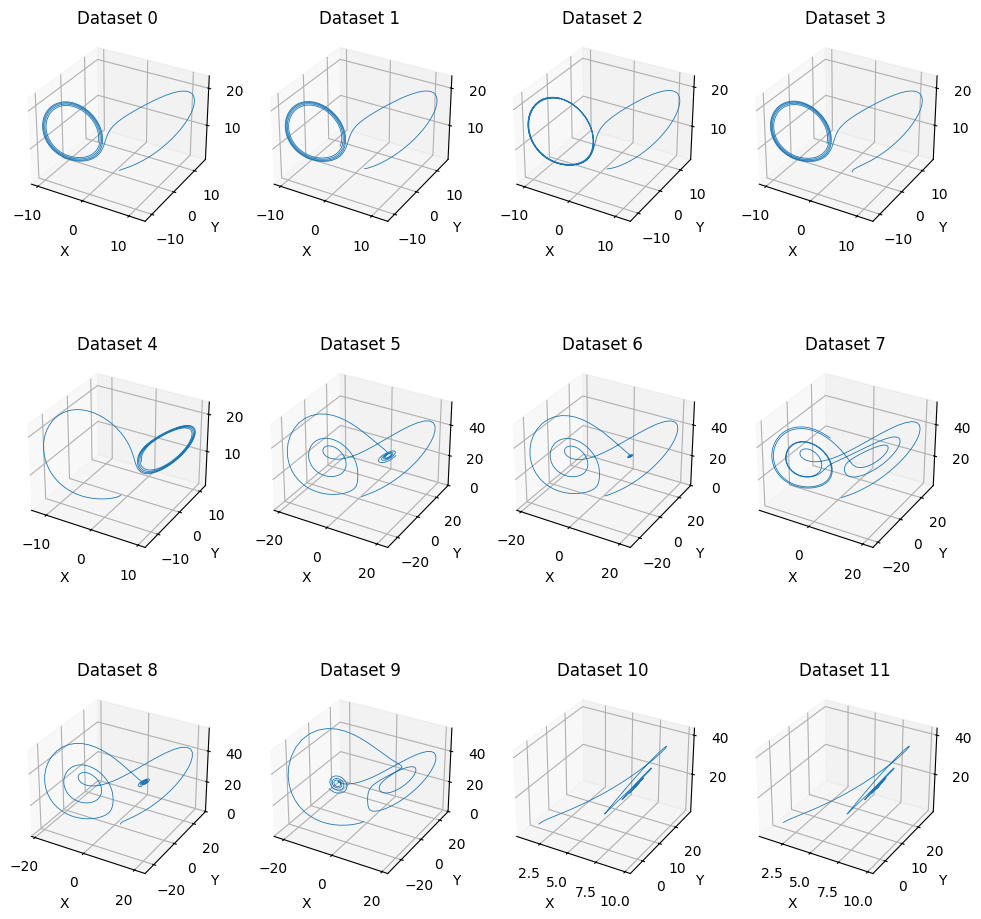

In [7]:
fig, ax = plt.subplots(ncols=4, nrows=int(len(datasets)/4), figsize=(12, 12), subplot_kw={'projection': '3d'})

titles = [f"Dataset {i}" for i in range(len(datasets))]
for i, [ax_, title] in enumerate(zip(ax.flat, titles)):
    ax_.plot(*datasets[i].X[:, 0:3].T, lw=0.6)
    ax_.set_title(title)
    ax_.set_xlabel("X")
    ax_.set_ylabel("Y")
    ax_.set_zlabel("Z")


In [8]:
def tune_parameters(X_train, y_train, X_val, y_val, evaluator = None):
    if not evaluator:
        evaluator = MeanSquaredError()
        
    def objective(trial):
        kernels = [
            GaussianKernel(bandwidth=trial.suggest_float(f"bandwidth_{i}", 1, 100))
            for i in range(X_train.shape[1])
        ]

        krr_model = KernelRidgeRegression(
            kernels=kernels,
            reg = trial.suggest_float("reg", 1e-12, 1e-1)
        )

        krr_model.fit(X_train, y_train)
        y_pred = krr_model.predict(X_val)

        return evaluator(y_val, y_pred)

    study = optuna.create_study()
    study.optimize(
        objective,
        n_trials=50,
        timeout=20*60
    )

    best_params = study.best_params

    return best_params

In [9]:
models = []
evaluator = MeanSquaredError()

for dataset in tqdm(datasets):
    X_train, y_train = dataset.train_data()
    X_test, y_test = dataset.test_data()
    X_val, y_val = dataset.val_data()

    # Run parameter tuning
    best_params = tune_parameters(X_train, y_train, X_val, y_val, evaluator)

    # Fit model
    kernels=[
            GaussianKernel(best_params[f"bandwidth_{i}"]) for i in range(dataset.X.shape[1])
        ]

    krr_model = KernelRidgeRegression(
        kernels=kernels,
        reg = best_params["reg"]
    )

    X_train_all = np.concatenate([X_train, X_val], axis=0)
    y_train_all = np.concatenate([y_train, y_val], axis=0)

    krr_model.fit(X_train_all, y_train_all)

    models.append(krr_model)

    # y_pred = krr_model.predict(X_test)

100%|██████████| 15/15 [00:30<00:00,  2.05s/it]


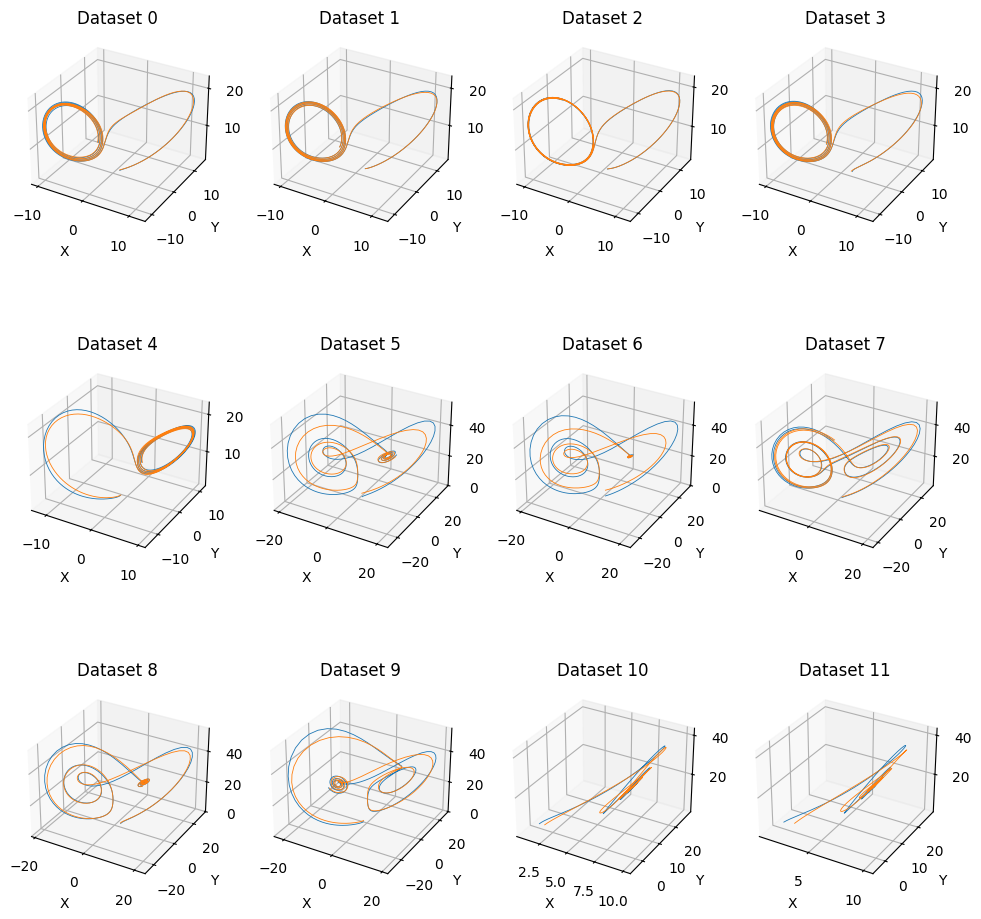

In [10]:
# Plot predictions as sanity check

fig, ax = plt.subplots(ncols=4, nrows=int(len(datasets)/4), figsize=(12, 12), subplot_kw={'projection': '3d'})

titles = [f"Dataset {i}" for i in range(len(datasets))]
for i, [ax_, title] in enumerate(zip(ax.flat, titles)):
    X, y = datasets[i].X, datasets[i].y
    y_pred = models[i].predict(X)
    ax_.plot(*y[:, 0:3].T, lw=0.6)
    ax_.plot(*y_pred[:, 0:3].T, lw=0.6)
    ax_.set_title(title)
    ax_.set_xlabel("X")
    ax_.set_ylabel("Y")
    ax_.set_zlabel("Z")

# Similarity

In [86]:
inner_product_matrix = np.zeros(shape=(len(datasets), len(datasets)))

kernel_common = GaussianKernel(bandwidth=1)

for di in tqdm(range(len(datasets))):
    for dj in range(di, len(datasets)):
        model1 = models[di]
        model2 = models[dj]

        ds1_xt, _ = datasets[di].train_data()
        ds1_xv, _ = datasets[di].val_data()
        ds1_x = np.concatenate([ds1_xt, ds1_xv], axis=0)
        ds1_x, _ = model1.reshape_data(ds1_x)

        ds2_xt, _ = datasets[dj].train_data()
        ds2_xv, _ = datasets[dj].val_data()
        ds2_x = np.concatenate([ds2_xt, ds2_xv], axis=0)
        ds2_x, _ = model2.reshape_data(ds2_x)

        model1_kernels = model1.kernels
        model2_kernels = model2.kernels

        model1_bandwidths = [model1_kernels[i].bandwidth for i in range(3)]
        model2_bandwidths = [model2_kernels[i].bandwidth for i in range(3)]

        model1_alphas = model1.alpha#.reshape(3, -1).T
        model2_alphas = model2.alpha#.reshape(3, -1).T

        inner_product_total = 0

        kernels = []

        for dim in range(3):
            Kc = kernel_common(
                x1 = ds1_x/model1_bandwidths[dim],
                x2 = ds2_x/model2_bandwidths[dim],
            )

            kernels.append(Kc)

        Kc = scipy.linalg.block_diag(*kernels)

        inner_product_matrix[di, dj] = model1_alphas.T@Kc@model2_alphas
        inner_product_matrix[dj, di] = inner_product_matrix[di, dj]


        #     inner_product = model1_alphas[:, dim].T @ Kc @ model2_alphas[:, dim]

        #     inner_product_total += inner_product

        # inner_product_matrix[di, dj] = inner_product_total
        # inner_product_matrix[dj, di] = inner_product_total

  0%|          | 0/15 [00:00<?, ?it/s]/tmp/ipykernel_818/4053650067.py:43: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  inner_product_matrix[di, dj] = model1_alphas.T@Kc@model2_alphas
100%|██████████| 15/15 [00:04<00:00,  3.68it/s]


In [87]:
distance_matrix = np.zeros_like(inner_product_matrix)
for i in range(inner_product_matrix.shape[0]):
    for j in range(inner_product_matrix.shape[1]):
        distance_matrix[i, j] = inner_product_matrix[i, i] + inner_product_matrix[j, j] - 2*inner_product_matrix[i, j] 


# Clustering

In [88]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform

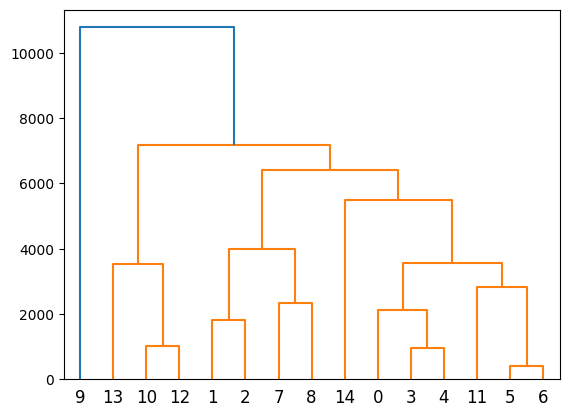

In [89]:
# Assuming D is your full distance matrix
condensed_D = squareform(distance_matrix)  # if D is a full matrix
Z = linkage(condensed_D, method='average')
plt.figure()
dendrogram(Z)
plt.show()

In [90]:
# Get cluster labels
labels = fcluster(Z, t=4, criterion='maxclust')  # t is number of clusters
labels

array([3, 2, 2, 3, 3, 3, 3, 2, 2, 4, 1, 3, 1, 1, 3], dtype=int32)

In [91]:
cluster_labels = pd.Series(labels)

In [92]:
for c in cluster_labels.unique():
    cluster_indices = cluster_labels[cluster_labels == c].index
    cluster_truth_labels = [datasets[i].dataset_label for i in cluster_indices]

    print(f"{c}: {cluster_truth_labels}")

3: [0, 0, 0, 1, 1, 2, 2]
2: [0, 0, 1, 1]
4: [1]
1: [2, 2, 2]


In [53]:
# for c in cluster_labels.unique():
#     cluster_indices = cluster_labels[cluster_labels == c].index

#     cluster_size = len(cluster_indices)

#     nrows = int(np.ceil(cluster_size/3))
#     ncols = min(len(cluster_indices), 3)

#     fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 8), subplot_kw={'projection': '3d'})

#     if nrows > 1:4, c
#         axes = ax.flat
#         for i in range(len(cluster_indices)):
#             axes[i].plot(*datasets[cluster_indices[i]].X.T)
#             axes[i].set_title(f"Dataset {cluster_indices[i]}")
    
#     elif ncols > 1:
#         for i in range(len(cluster_indices)):
#             ax[i].plot(*datasets[cluster_indices[i]].X.T)
#             ax[i].set_title(f"Dataset {cluster_indices[i]}")

#     else:
#         ax.plot(*datasets[cluster_indices[0]].X.T)
#         ax.set_title(f"Dataset {cluster_indices[0]}")

In [54]:
# dataset_labels = pd.Series([d.dataset_label for d in datasets])

# for d in dataset_labels.unique():
#     dataset_indices = dataset_labels[dataset_labels == d].index

#     cluster_size = len(dataset_indices)

#     nrows = int(np.ceil(cluster_size/3))
#     ncols = min(len(dataset_indices), 3)

#     fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 8), subplot_kw={'projection': '3d'})

#     if nrows > 1:
#         axes = ax.flat
#         for i in range(len(dataset_indices)):
#             axes[i].plot(*datasets[dataset_indices[i]].X.T)
#             axes[i].set_title(f"Dataset {dataset_indices[i]}")
    
#     elif ncols > 1:
#         for i in range(len(dataset_indices)):
#             ax[i].plot(*datasets[dataset_indices[i]].X.T)
#             ax[i].set_title(f"Dataset {dataset_indices[i]}")

#     else:
#         ax.plot(*datasets[dataset_indices[0]].X.T)
#         ax.set_title(f"Dataset {dataset_indices[0]}")